# Matrix Encoding and Permanent Estimation

_This notebook was developed by Ana Filipa Carvalho._

This notebook is part of a series of notebooks with the code to reproduce results from this [REFERENCE] paper. This first contains the initial steps namely the encoding function *to_unitary()* and permanent estimation. In order to do that, the notebook is organised as follows:
- Random graph generation (to test our encoding function and later to be used to test algorithms for applications).
- *to_unitary()* function
- State preparation and post-selection (for permanent estimation).
- *perm_estimation()* function to estimate the permanent and obtain some statistics around it (estimation with increase of edge connectivity, ...).

To run these notebooks, you will need to install **Perceval**, a software tool developed by Quandela that we use to simulate the photonic device.

In [1]:
import numpy as np
from numpy import linalg
from scipy.linalg import sqrtm

import networkx as nx

import perceval as pcvl
import perceval.components as comp
from perceval.algorithm import Sampler

import quandelibc as qc
import matplotlib.pyplot as plt


In [2]:
def random_graph_generation(n_nodes, p1, n_densest=0, p2=0):
    '''Generates a random graph with:
           .n_nodes as number of nodes and edge connectivity determined by probability p1
           .n_densest - a subgraph of size n_densest with edge conections given by p2
    '''
    G1 = nx.Graph()
    G1.add_nodes_from([k for k in range(n_nodes-n_densest)])

    # adding edges with probability p1 for the given nodes
    for i in range(n_nodes-n_densest):
        for j in range(i + 1, n_nodes-n_densest):
            r = np.random.random()
            if r < p1:
                G1.add_edge(i, j)

    # adding edges with probability p2 for selected nodes with probability p2
    G2 = nx.Graph()
    G2.add_nodes_from([k for k in range(n_nodes-n_densest, n_nodes)])

    # adding edges with probability p1 for the given nodes
    for i in range(n_nodes-n_densest, n_nodes):
        for j in range(i+1, n_nodes):
            r = np.random.random()
            if r < p2:
                G2.add_edge(i, j)

    G = nx.compose(G1, G2)
    if n_densest != 0:
        #n_connect=round(min(n_densest, n_nodes-n_densest)/2)+1
        n_connect = round(n_densest/2)+1
        for i in range(n_connect):
            node1 = np.random.randint(n_nodes-n_densest)
            node2 = np.random.randint(n_nodes-n_densest, n_nodes)
            G.add_edge(node1, node2)

    # so there is not isolated parts
    if list(nx.isolates(G)) != [] or len(list(G.subgraph(c) for c in nx.connected_components(G))) > 1:
        G1.clear()
        G2.clear()
        G.clear()
        G = random_graph_generation(n_nodes, p1, n_densest, p2)

    return G


We construct *AdjToUnit()* now. Considering the singular value decomposition of $A$, from the theory part in the paper we have that if $$A=U\Sigma V^T \text{ and } s=\sigma_{max}(A)$$
then we can embed $A$ into a doubled-size unitary $U_A$ with the form:
$$U_A:=\begin{pmatrix}
A_s & \sqrt{I_{n \times n} -A_s(A_s)^{T}} \\
\sqrt{I_{n \times n} -(A_s)^{T}A_s}  & -(A_s)^{T}\\
\end{pmatrix}$$

In [3]:
def to_unitary(A):
    ''' Input: graph A either as:
                                 an adjacency matrix of size mxm
                                 a networkX graph with m nodes
        Output: unitary with size 2mx2m
    '''

    if type(A) == type(nx.Graph()):
        A = nx.to_numpy_array(A)
    P1, D, V = linalg.svd(A)

    c = np.max(D)
    # if it is not complex, then np.sqrt will output nan in complex values
    An = np.matrix(A/c, dtype=complex)
    P = An
    m = len(An)
    Q = sqrtm(np.identity(m)-np.dot(An, An.conj().T))
    R = sqrtm(np.identity(m)-np.dot(An.conj().T, An))
    S = -An.conj().T
    Ubmat = np.bmat([[P, Q], [R, S]])
    Ubmat = Ubmat.real #to eliminate those 
    return (np.copy(Ubmat), c)


With *to_unitary()* defined, now we can estimate the permanent of a graph by generating samples. Following the schematic on figure below, we create functions *input_state()* and *post_select()* to preparate the initial state and select the appropriate ones at the output. Finally, everything is combined in *perm_estimation()* function. 

![BS encoding scheme](BSdevice_graphs.png)

In [4]:
def input_state(m):
    '''input state for selection of our m modes
        returns |1,1,1,...,0,0,0> m ones and m zeros'''
    return np.append(np.ones(m), np.zeros(m)).astype(int)

input_state(4)


array([1, 1, 1, 1, 0, 0, 0, 0])

In [5]:
# Post selection of samples with photons only on first half modes
def post_select(samples):
    ''''post select on states that have all modes from m to 2*m as vacuum
        can't have collision of first half'''
    a = []
    m = int(len(samples[0])/2)
    for state in samples:
        state = list(state)
        if all(ele == state[m-1] for ele in state[:m]) and state[m-1] == 1:
            # do not need to check if there is vacuum in the second half for several reasons!
            a.append(state)
    return a

Computing the permanent estimation by generating samples.

$$permE(A)=s^n PermE(A_s)=s^n\sqrt{\frac{ \text{Accepted samples} }{\text{Total number of samples}}}$$

In [6]:
def perm_estimation(G, nb_samples, Ns_min=0):
    '''Function to estimate the permanent given a graph G, a number of samples Ns and the minimum number of samples Ns_min
    Recal that Ns is the number of samples to generate but, due to post-selection, we add Ns_min so that we don't do estimations with accepted samples to be zero
    '''
    if Ns_min == 0:
        Ns_min = Ns

    #Sampling_Backend = pcvl.BackendFactory().get_backend("SLOS")
    m = G.number_of_nodes()
    in_state = input_state(m)

    U, c = to_unitary(G)
    U_matrix_pcvl = pcvl.Matrix(U)
    unitary_component = comp.Unitary(U_matrix_pcvl)
    proc = pcvl.Processor("SLOS", unitary_component)
    proc.with_input(pcvl.BasicState( in_state))
    #simulator = Sampling_Backend(U)

    samples = []
    i = 0
    sampler = Sampler(proc)
    while len(samples) < Ns_min:
        samples = sampler.samples(nb_samples)['results']
        samples = post_select(samples)
        i = i+1
    print("Total number of samples: ", Ns*i)
    print("Number of samples post:", len(samples))
    perm = (c**m)*np.sqrt(len(samples)/(Ns*i))
    return perm


In [6]:
def perm_estimation(G, nb_samples, Ns_min=0):
    if Ns_min == 0:
        Ns_min = nb_samples

    if type(G) == type(nx.Graph()):
        m = G.number_of_nodes()
    else:
        m = len(G)
    in_state = input_state(m)

    U, c = to_unitary(G)
    U_matrix_pcvl = pcvl.Matrix(U)
    unitary_component = comp.Unitary(U_matrix_pcvl)
    proc = pcvl.Processor("CliffordClifford2017", unitary_component)
    proc.with_input(pcvl.BasicState(in_state))

    samples_accepted = []
    i = 0
    sampler = Sampler(proc)
    while len(samples_accepted) < Ns_min:
        samples_accepted.append(list(sampler.samples(nb_samples)['results']))
        samples_accepted = post_select(samples_accepted)
        i = i+1
    print("Total number of samples: ", nb_samples*i)
    print("Number of samples post:", len(samples_accepted))
    perm = (c**m)*np.sqrt(len(samples_accepted)/(nb_samples*i))
    return perm

In [6]:
def perm_estimation(G, nb_samples, Ns_min=0):
    if Ns_min == 0:
        Ns_min = nb_samples

    if type(G) == type(nx.Graph()):
        m = G.number_of_nodes()
    else:
        m = len(G)
    in_state = input_state(m)

    U, c = to_unitary(G)
    U_matrix_pcvl = pcvl.Matrix(U)
    unitary_component = comp.Unitary(U_matrix_pcvl)
    proc = pcvl.Processor("CliffordClifford2017", unitary_component)
    proc.with_input(pcvl.BasicState(in_state))

    samples_accepted = []
    i = 0
    sampler = Sampler(proc)
    while len(samples_accepted) < Ns_min:
        samples = list(sampler.samples(nb_samples)['results'])
        samples_accepted += post_select(samples)
        i = i+1
    print("Total number of samples: ", nb_samples*i)
    print("Number of samples post:", len(samples_accepted))
    perm = (c**m)*np.sqrt(len(samples_accepted)/(nb_samples*i))
    return perm

Plotting estimation and exact value for permanent over the edge connectivity (probability parameter in *random_graph_generation()*). The plots can vary a lot because that are a lot of variables that can change. Increasing the number of graphs to consider for the mean, increasing the number of samples for each estimation, all of these would help have a plot but since the generation is probabilistic, it should always vary a little.

[0.7  0.78 0.86 0.94 1.  ]
[(150+0j)]
[(1146.8666666666666+0j)]
[(150+0j), (289.3333333333333+0j)]
[(1146.8666666666666+0j), (3439.5333333333333+0j)]
[(150+0j), (289.3333333333333+0j), (695.3333333333334+0j)]
[(1146.8666666666666+0j), (3439.5333333333333+0j), (4152.133333333333+0j)]
[(150+0j), (289.3333333333333+0j), (695.3333333333334+0j), (1211.4666666666667+0j)]
[(1146.8666666666666+0j), (3439.5333333333333+0j), (4152.133333333333+0j), (9513.333333333334+0j)]
[(150+0j), (289.3333333333333+0j), (695.3333333333334+0j), (1211.4666666666667+0j), (1854+0j)]
[(1146.8666666666666+0j), (3439.5333333333333+0j), (4152.133333333333+0j), (9513.333333333334+0j), (14833+0j)]


/Users/filipagoncalvescarvalho/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


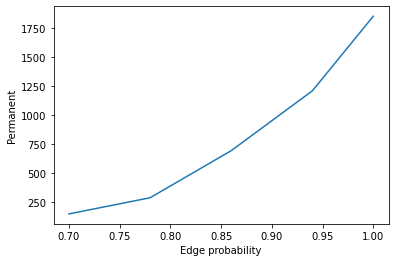

In [7]:
probs = np.append(np.arange(0.7, 1, 0.08), 1)
print(probs)
exactList1 = []
exactList2 = []
for i in probs:
    exactValues1 = [qc.permanent_cx(nx.to_numpy_array(
        random_graph_generation(7, i))) for _ in range(15)]
    exactList1.append(np.mean(exactValues1))
    print(exactList1)
    exactValues2 = [qc.permanent_cx(nx.to_numpy_array(
        random_graph_generation(8, i))) for _ in range(15)]
    exactList2.append(np.mean(exactValues2))
    print(exactList2)

plt.plot(probs, exactList1, label="Size 7")

# plt.legend()
plt.xlabel('Edge probability')
plt.ylabel('Permanent')
plt.show()

/Users/filipagoncalvescarvalho/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


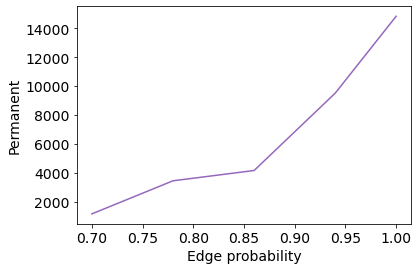

In [8]:
plt.plot(probs, exactList2, label="Size 8", color='tab:purple')
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)

# plt.legend()
plt.xlabel('Edge probability', fontsize = 14)
plt.ylabel('Permanent', fontsize = 14)
plt.show()

The two plots above reproduce figures $4$ and $5$ of the paper. We see the mean value of the permanent of $15$ randomly generated graphs of $8$ (or $7$, respectively) vertices, plotted in function of edge probability. The edge probability represents the probability that any two vertices $i$ and $j$ of the randomly generated graph are connected by an edge.

For the last code in this notebook, you can use it to reproduce figure 6 from the paper where we plot the mean value of estimation and calculation of the permanent for random graphs of sizes 6.

[0.7  0.78 0.86 0.94 1.  ]
i in probs: 0.7
Total number of samples:  6127000
Number of samples post: 500
Total number of samples:  29852000
Number of samples post: 500
Total number of samples:  1273000
Number of samples post: 500
Total number of samples:  2224000
Number of samples post: 500
i in probs: 0.7799999999999999
Total number of samples:  1671000
Number of samples post: 500
Total number of samples:  23356500
Number of samples post: 500
Total number of samples:  3599500
Number of samples post: 500
Total number of samples:  2005500
Number of samples post: 500
i in probs: 0.8599999999999999
Total number of samples:  1688000
Number of samples post: 500
Total number of samples:  1585500
Number of samples post: 502
Total number of samples:  1985000
Number of samples post: 500
Total number of samples:  1750500
Number of samples post: 500
i in probs: 0.9399999999999998
Total number of samples:  2090000
Number of samples post: 500
Total number of samples:  2010000
Number of samples post

/var/folders/8v/r85qsjj96qn5kpsdfhrz1g2h0000gp/T/ipykernel_22833/2655738150.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ob" (-> color='b'). The keyword argument will take precedence.
  plt.plot(probs, exact_list, "ob", label="Exact Value", color='C0')
/Users/filipagoncalvescarvalho/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/8v/r85qsjj96qn5kpsdfhrz1g2h0000gp/T/ipykernel_22833/2655738150.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ob" (-> color='b'). The keyword argument will take precedence.
  plt.plot(probs, estimation_list, "ob",


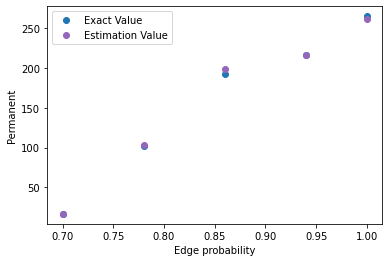

In [11]:
Ns = 500
m = 6
probs = np.append(np.arange(0.7, 1, 0.08), 1)
print(probs)
estimation_list = []; exact_list = []
for i in probs:
    print("i in probs:", i)
    estimation_values = []; exact_values = []
    for _ in range(4):
        random_graph = random_graph_generation(m, i)
        estimation_values.append( perm_estimation(random_graph, Ns) )
        exact_values.append( qc.permanent_cx(nx.to_numpy_array(random_graph)) )

    estimation_list.append(np.mean(estimation_values))
    exact_list.append(np.mean(exact_values))

print("exact_list", exact_list)
print("estimation_list", estimation_list)
plt.plot(probs, exact_list, "ob", label="Exact Value", color='C0')
plt.plot(probs, estimation_list, "ob",
         label="Estimation Value", color='tab:purple')

plt.legend()
plt.xlabel('Edge probability')
plt.ylabel('Permanent')
plt.show()